In [2]:
import pylab
import numpy as np
np.seterr(all='raise')
np.random.seed(13)
import scipy as sp
import pandas as pd # tablas de datos -> bases datos
import seaborn as sns; sns.set() # graficar (sobre matplotlib) ampliar la funcionalidad de matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('text', usetex=True)
%matplotlib inline
# from tqdm import tqdm

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

### Omitir por el momento

In [ ]:
def calc_error(res,e,names=[]):
    tmp_i = np.zeros(len(res.x))
    etol = e * max(1, abs(res.fun))
    for i in range(len(res.x)):
        tmp_i[i] = 1.0
        hess_inv_i = res.hess_inv(tmp_i)[i]
        uncertainty_i = np.sqrt(etol * hess_inv_i)
        tmp_i[i] = 0.0
        if len(names) > 0:
            print('{0} = {1:12.4e} ± {2:.1e}'.format(names[i], res.x[i], uncertainty_i))
        else:
            print('x^{0} = {1:12.4e} ± {2:.1e}'.format(i, res.x[i], uncertainty_i))

# Revisar bases de datos conocidas
[SciKit Learn](https://scikit-learn.org/stable/datasets/index.html)
<!-- X,Y = datasets.load_boston(return_X_y=True) -->

In [69]:
A = pd.DataFrame(housing['data'], columns=housing['feature_names'])
b = pd.DataFrame(housing['target'], columns=["MEDV"])
A.insert(0,'c0',1)

In [70]:
A

,c0,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,1,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,1,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,1,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,1,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,1,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


$$\mathbb{A}\cdot\vec{x} + c_0 \cdot \mathbb{1} = \vec{b} $$

Tenemos que utilizar minimimos cuadrados?

$$MSE=\min_{\vec{x}} || \vec{b} - \mathbb{A}\cdot\vec{x} ||^2$$



$$\vec{x} = (\mathbb{A}^T\cdot\mathbb{A})^{-1}\cdot\mathbb{A}^T\vec{b} $$

y = rho()*sigma_y/sigma_x

$$X = x_1+x_2+x_3+\dots$$
Mi intención,
$$CRIM\times x_1+ZN\times x_2+INDUS\times x_3+\dots = b$$

In [71]:
Anumpy = np.matrix(A.to_numpy(dtype=np.float32)) # ""
bnumpy = np.matrix(b.to_numpy(dtype=np.float32))

In [72]:
# %%timeit
X_opt = np.linalg.inv(Anumpy.T*Anumpy)*Anumpy.T*bnumpy

In [73]:
print(X_opt.T)

[[-3.7484428e+01  4.3536872e-01  9.3336608e-03 -1.0601799e-01
   6.4089394e-01 -4.3013570e-06 -3.7718164e-03 -4.2704299e-01
  -4.4078553e-01]]


In [74]:
np.array(Anumpy*X_opt).flatten()

array([4.128294  , 3.9739418 , 3.6751823 , ..., 0.16096497, 0.3091488 ,
       0.50494385], dtype=float32)

/opt/conda3/envs/fisi2028/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


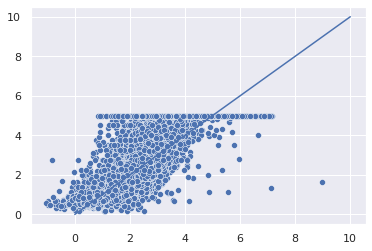

In [75]:
sns.scatterplot(np.array(Anumpy*X_opt).flatten(),np.array(bnumpy).flatten())
plt.plot([0,10],[0,10])

In [76]:
predicciones = np.array(Anumpy*X_opt).flatten()

In [77]:
observaciones = np.array(bnumpy).flatten()
bbarrita = observaciones.mean()

In [78]:
r2 = 1-(np.linalg.norm(predicciones - observaciones)**2)/(np.linalg.norm(observaciones - bbarrita)**2)

In [79]:
r2

0.6062140614934268

# Implementemos nuestro algoritmo de Optimización por Newton Raphson
La idea es encontrar $X_{opt}$ de forma iterativa sin invertir la matriz

In [ ]:
# Definamos la func de costo (debe devolver un escalar)
def L(x,A,b):
    # (b_pred-b_obs)^2
    # m es el numero de datos
    # n es el numero de parametros == 13
    m,n = A.shape
    X = np.matrix(x).T
    DeltaB=(A*X-b)
    return (DeltaB.T*DeltaB)[0,0]/m
def dLdx(x,A,b):
    # (b_pred-b_obs)^2
    # m es el numero de datos
    # n es el numero de parametros == 13
    m,n = A.shape
    X = np.matrix(x).T
    DeltaB=(A*X-b)
    return (2/m)*np.array(A.T*DeltaB).flatten()

In [ ]:
# encontrar una forma iterativa de actualizar X para ir minimizando la funcion de costo L
x = np.zeros(Anumpy.shape[1])
epsilon = 2e-6
cost = []
N = 100
for it in range(N):
    x = x - epsilon*dLdx(x,Anumpy,bnumpy)
    cost.append(L(x,Anumpy,bnumpy))
sns.scatterplot(np.arange(N)+1,cost)
# plt.xscale('log')
# plt.yscale('log')

In [ ]:
L(np.array(X_opt).flatten(),Anumpy,bnumpy)

In [ ]:
np.array(X_opt).flatten()

In [ ]:
e=1e-10

In [ ]:
# %%timeit
res1 = sp.optimize.minimize(fun=L,jac=dLdx, x0=np.zeros(Anumpy.shape[1]), args = (Anumpy,bnumpy), method='Newton-CG', tol=e)
res1

In [ ]:
res2 = sp.optimize.minimize(fun=L,jac=dLdx, x0=np.zeros(Anumpy.shape[1]), args = (Anumpy,bnumpy), method='L-BFGS-B', tol=e)
res2

In [ ]:
L(res1.x,Anumpy,bnumpy)

In [ ]:
L(res2.x,Anumpy,bnumpy)

In [ ]:
L(np.array(X_opt).flatten(),Anumpy,bnumpy)

In [ ]:
calc_error(res2,e,names=[])

# Fit a funciones no lineales

In [ ]:
print("Nuestra caja experimental!")
a = 3/2
b = 4
c = -3
N=100
x = np.linspace(0.2,10,N)
y = a/(1+np.exp(c*(x-b)))
x1 = x + np.random.exponential(0.01,size=N)
y1 = y + np.random.normal(0,0.05,size=N)
x2 = x + np.random.normal(0,0.03,size=N)
y2 = y + np.random.exponential(0.05,size=N)

In [ ]:
sns.scatterplot(x1,y1)

In [ ]:
sns.scatterplot(x2,y2)

# ¿Cómo hacer el fit a la función?
$$f(x) = a\frac{1}{1+e^{bx+c}}$$

In [ ]:
#como encuentro yo a, b y c?
# cual seria nuestra funcion de costo
def f(parametros,x):
    return parametros[0]/(1+np.exp(parametros[1]*x+parametros[2]))
def Lfit(parametros,x,y):
    # L = promedio sobre todos los puntos (f(a,b,c;x)-y)^2
    # parametros np.array([a,b,c])
    deltaY=f(parametros,x) - y
    return np.dot(deltaY,deltaY)/len(y)

In [ ]:
print("Ajuste para el primer set: x1,y1")
e=1e-8
# ansatz: a=1,b=0,c=0
res1 = sp.optimize.minimize(fun=Lfit, x0=np.array([1,0,0]), args = (x1,y1), method='L-BFGS-B', tol=e)
res1

In [ ]:
y1_pred = f(res1.x,x1)
sns.scatterplot(x1,y1)
plt.plot(x1,y1_pred,color='r')

In [ ]:
r2 = 1-np.sum((y1_pred-y1)**2)/np.sum((y1-y1.mean())**2)
r2

In [ ]:
calc_error(res1,e,names=['a','b','c'])

# ¿Cómo hacer el fit a la función?
$$f(x) = a + b\tanh(cx+d)$$

In [ ]:
#como encuentro yo a, b y c?
# cual seria nuestra funcion de costo
def ftilde(parametros,x):
    return parametros[0]+parametros[1]*np.tanh(parametros[2]*x+parametros[3])
def Lfit(parametros,x,y):
    # L = promedio sobre todos los puntos (f(a,b,c,d;x)-y)^2
    # parametros np.array([a,b,c,d])
    deltaY=ftilde(parametros,x) - y
    return np.dot(deltaY,deltaY)/len(y)

In [ ]:
print("Ajuste para el primer set: x1,y1")
e=1e-8
# ansatz: a=0,b=1,c=0,d=0
res1 = sp.optimize.minimize(fun=Lfit, x0=np.array([0,1,0,0]), args = (x1,y1), method='L-BFGS-B', tol=e)
res1

In [ ]:
y1_pred = ftilde(res1.x,x1)
sns.scatterplot(x1,y1)
plt.plot(x1,y1_pred,color='r')

In [ ]:
r2 = 1-np.sum((y1_pred-y1)**2)/np.sum((y1-y1.mean())**2)
r2

In [ ]:
calc_error(res1,e,names=['a','b','c','d'])